# Check GPU


⭐  Note: in Google Colab, the GPU runtime typically has a P100 connected. The P100 has compute capability 6.0 and is not expected to show a significant speedup.

To use **mixed precision training** `Mixed precision for training neural networks can reduce training time and memory requirements without affecting model performance` 
GPU compute capability >=7.0

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-eb8327c3-2ef1-3d6f-d15d-ae3c6d5c3a68)


Compute capability (Tesla K80 ) = 3.8

so this will not work..

we want `Tesla T4` which has compute capability of 7.5 and offer by google colab

# Get helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-04-13 12:50:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-04-13 12:50:06 (117 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Get Data

## **here we use Tensorflow Datasets to get data**

for [more information](https://www.tensorflow.org/datasets/overview)

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
dataset_list=tfds.list_builders()

print("food101" in dataset_list)

True


In [ ]:
(train_data,test_data),ds_info=tfds.load(name='food101',
                                         split=["train","validation"],
                                         shuffle_files=True,
                                         as_supervised=True,  # give in tuple (data,label)
                                         with_info=True)      # meta data

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteUFSST6/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteUFSST6/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


# Become one with data

In [ ]:
# meta data
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# class names of data
class_names=ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
tf.Tensor(
[[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]

 [[ 77  80  89]
  [ 75  78  87]
  [ 82  86  95]
  ...
  [115 189 252]
  [117 192 255]
  [118 194 255]]

 ...

 [[159 166 194]
  [154 161 187]
  [171 178 204]
  ...
  [219 216 235]
  [223 220 239]
  [227 226 244]]

 [[170 179 208]
  [169 179 206]
  [173 183 210]
  ...
  [218 217 235]
  [223 222 240]
  [226 227 245]]

 [[168 177 206]
  [170 179 208]
  [152 162 189]
  ...
  [224 223 241]
  [228 229 247]
  [231 232 250]]], shape=(512, 512, 3), dtype=uint8)
tf.Tensor(16, shape=(), dtype=int64)


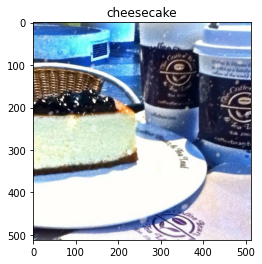

In [ ]:
# Take 1 sample of train data
import matplotlib.pyplot as plt

one_sample=train_data.take(1)

print(one_sample)

for x in one_sample:
  print(x[0])
  print(x[1])

  plt.imshow(x[0])
  plt.title(class_names[x[1].numpy()])
  
  

In [ ]:
# minimum and maximum pixel value

import tensorflow as tf

tf.reduce_min(x[0]),tf.reduce_max(x[0])

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

# Create preprocesing funtion

* image-size= not fixed
* max-pixel value=255
* min-pixel value=0
* dtype of image=unit8
* dtype of label=int32


---

we are going to make

* image size=224x224
* batch-size=32
* Normalize our pixel values (0~1)
* dtype of an image unit8==>float32 ( mixed precision )

As we are going to use EffiientNetB(i) we don't require rescaling beacuse it is inbuilt in their architecture.

In [ ]:
# preprocessing function

def preprocess_img(image,label,image_shape=224):
  """ convert image dtype from unit8 to float32,reshapes 
      image to [image_shape,image_shape,color_channel]
  """
  image=tf.image.resize(image,[image_shape,image_shape]) # target image
  return tf.cast(image,tf.float32),label


In [ ]:

sample_image=x[0]
preprocessed_image=preprocess_img(x[0],x[1])[0]

In [ ]:
print("Before preprocessing...")
print(f"""
sample image shape : {sample_image.shape}
sample image dtype : {sample_image.dtype}
""")

print("After preprocessing...")
print(f"""
preprocessed image shape : {preprocessed_image.shape}
preprocessed image dtype : {preprocessed_image.dtype}
""")

Before preprocessing...

sample image shape : (512, 512, 3)
sample image dtype : <dtype: 'uint8'>

After preprocessing...

preprocessed image shape : (224, 224, 3)
preprocessed image dtype : <dtype: 'float32'>



# Batch & prepare our dataset

In [ ]:
# map preprocess function to training data (by parallel processing)
train_data=train_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)

# shuffle our training data then make batches and prefetch it for faster to load
train_data=train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

# now same process for testing data
test_data=test_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=1000)


In [ ]:
train_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

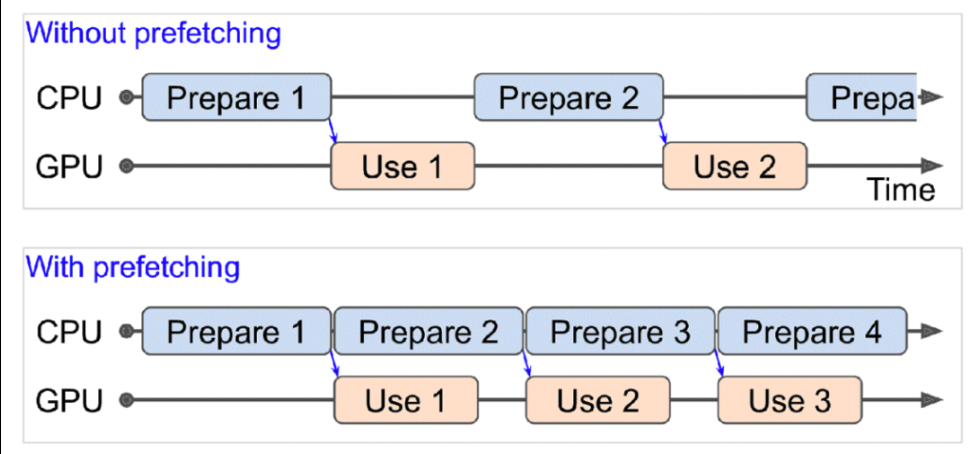

**What prefetch doing** ❓

generally batches are prepare on CPU but our computation is performed on GPU , so when our data is not prefetched only in batches

---
CPU(prepare batch 1 for comptn.) ➡ GPU(batch 1 comptn.) ➡ CPU(prepare batch 2 for comptn.) ➡ GPU (batch 2 computn)...so on.

---
It is like while performing computation on GPU , CPU prepare batch so it is ready for computation as GPU complete computation of previous batch.
No wait for prepare batch on CPU and then switch it to GPU.




# Create model Callbacks


Callbacks:

* tensorboard callback : to log training results
* ModelCheckpoint callback : to save model's performance

In [ ]:
# import from helper function

from helper_functions import create_tensorboard_callback

# create ModelCheckpoint callback
checkpoint_path='model_Checkpoints/cp.ckpt'
modelcheckpoint_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                            monitor='val_loss',
                                                            save_best_only=True,
                                                            save_weights_only=True,
                                                            verbose=0)



# Mixed precision training

In [ ]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


# Feature extracted model

In [ ]:
from tensorflow.keras import layers 
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
len(class_names)

101

In [ ]:
# Data Augumented as rotated,flipped,cropped..

Data_augumentaion=tf.keras.Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2)
],name="data_augumentation")


In [ ]:
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

input=layers.Input(shape=(224,224,3),name='input_layer')
x=Data_augumentaion(input)
x=base_model(x,training=False)

x=layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
x=layers.Dense(len(class_names))(x)
output=layers.Activation(activation='softmax',dtype=tf.float32,name='softmax_mixed_output_layer')(x)

model=tf.keras.Model(input,output)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augumentation (Sequent  (None, 224, 224, 3)      0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dense_9 (Dense)             (None, 101)               129381    
                                                                 
 softmax_mixed_output_layer   (None, 101)              0   

In [ ]:
for layer in model.layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <Policy "float32">
data_augumentation True float32 <Policy "mixed_float16">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling_layer True float32 <Policy "mixed_float16">
dense_9 True float32 <Policy "mixed_float16">
softmax_mixed_output_layer True float32 <Policy "float32">


**we have used mixed precision as global policy:**

* layer.dtype 🐾 layer stores variables in this format
* layer.dtype_policy 🐾 layer performs computation in this format


so we can see that layer stores variable in `float32` and using `mixed_float16` for computation.

# fit the feature extraction model

In [ ]:
history_101=model.fit(train_data,
                      epochs=3,  # prefer 3 epochs ,over it overfitting occur
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=int(0.15*len(test_data)),
                      callbacks=[
                                 create_tensorboard_callback("training_logs","EfficientNet"),
                                 modelcheckpoint_callback
                      ]
                      )

Saving TensorBoard log files to: training_logs/EfficientNet/20220409-103001
Epoch 1/3
2368/2368 [==============================] - 252s 70ms/step - loss: 2.2269 - accuracy: 0.4657 - val_loss: 1.3974 - val_accuracy: 0.6303
Epoch 2/3
2368/2368 [==============================] - 163s 68ms/step - loss: 1.7400 - accuracy: 0.5610 - val_loss: 1.2844 - val_accuracy: 0.6570
Epoch 3/3
2368/2368 [==============================] - 165s 69ms/step - loss: 1.6158 - accuracy: 0.5876 - val_loss: 1.2436 - val_accuracy: 0.6626


In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 47s 59ms/step - loss: 1.2586 - accuracy: 0.6620


[1.258626937866211, 0.6619802117347717]

# Fine tuning

In [ ]:
# unfreeze some layers
base_model.trainable=True

for x in base_model.layers[:-25]:
  x.trainable=False


initial_epoch=history_101.epoch

fine_tune_epoch=len(initial_epoch)+2

history_101_fine_tune=model.fit(train_data,
                    epochs=fine_tune_epoch,
                    validation_data=test_data,
                    validation_steps=int(0.15*len(test_data)),
                    initial_epoch=len(initial_epoch)-1)



Epoch 3/5
2368/2368 [==============================] - 165s 69ms/step - loss: 1.5458 - accuracy: 0.6048 - val_loss: 1.2216 - val_accuracy: 0.6668
Epoch 4/5
2368/2368 [==============================] - 175s 73ms/step - loss: 1.4886 - accuracy: 0.6163 - val_loss: 1.2104 - val_accuracy: 0.6690
Epoch 5/5
2368/2368 [==============================] - 165s 69ms/step - loss: 1.4529 - accuracy: 0.6222 - val_loss: 1.2074 - val_accuracy: 0.6761


In [ ]:
initial_epoch=history_101_fine_tune.epoch

fine_tune_epoch=len(initial_epoch)+5

history=model.fit(train_data,
                    epochs=fine_tune_epoch,
                    validation_data=test_data,
                    validation_steps=int(0.15*len(test_data)),
                    initial_epoch=len(initial_epoch)-1)

Epoch 3/8
2368/2368 [==============================] - 171s 71ms/step - loss: 1.4213 - accuracy: 0.6278 - val_loss: 1.1885 - val_accuracy: 0.6735
Epoch 4/8
2368/2368 [==============================] - 166s 69ms/step - loss: 1.3974 - accuracy: 0.6358 - val_loss: 1.1894 - val_accuracy: 0.6796
Epoch 5/8
2368/2368 [==============================] - 167s 70ms/step - loss: 1.3738 - accuracy: 0.6389 - val_loss: 1.1946 - val_accuracy: 0.6819
Epoch 6/8
2368/2368 [==============================] - 166s 69ms/step - loss: 1.3604 - accuracy: 0.6427 - val_loss: 1.1774 - val_accuracy: 0.6827
Epoch 7/8
2368/2368 [==============================] - 169s 71ms/step - loss: 1.3388 - accuracy: 0.6468 - val_loss: 1.1824 - val_accuracy: 0.6864
Epoch 8/8
2368/2368 [==============================] - 165s 69ms/step - loss: 1.3301 - accuracy: 0.6477 - val_loss: 1.1964 - val_accuracy: 0.6788


In [ ]:
model.evaluate(test_data)

790/790 [==============================] - 61s 76ms/step - loss: 1.2144 - accuracy: 0.6751


[1.2143995761871338, 0.6750891208648682]

In [ ]:
tf.keras.models.save_model(model,"fine_tune_model_1.h5")

In [ ]:
tf.keras.models.save_model(model,"/content/drive/MyDrive/Colab Notebooks/models/food_vision_fine_tune_model_1.h5")

# Save Model

In [ ]:
loaded_model=tf.keras.models.load_model('/content/07_efficientnetb0_fine_tuned_101_classes_mixed_precision')

In [ ]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 55s 66ms/step - loss: 0.9073 - accuracy: 0.8017


[0.9072548747062683, 0.8017029762268066]

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/models/food_vision_fine_tune_model_1.h5')

# Save as TFlite 

In [ ]:
converter=tf.lite.TFLiteConverter.from_keras_model(model)


In [ ]:
converter.target_spec.supported_ops=[
  tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS                                    
]

In [ ]:
tfmodel = converter.convert() 
open ('/content/drive/MyDrive/Colab Notebooks/models/food_vision_model.tflite' , "wb") .write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmpt935xfhp/assets


INFO:tensorflow:Assets written to: /tmp/tmpt935xfhp/assets


8689052